In [4]:
import plot
from scipy.special import expit
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from copy import deepcopy
import shap
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import dill as pickle
import copy
%matplotlib inline

This is based on scikit-learn example [Logistic function](https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic.html#sphx-glr-auto-examples-linear-model-plot-logistic-py)

In [5]:
try:
    with open('dataset.pickle', 'rb') as f:
        print('Loaded cached dataset')
        X, y, feature_names, n_features, n_samples, decision_rule = pickle.load(f)
except FileNotFoundError:
    print('No cached dataset found')

Loaded cached dataset


In [3]:
try:
    with open('classifiers.pickle', 'rb') as f:
        clf_a, clf_b = pickle.load(f)
        print('Loaded cached models')
except FileNotFoundError:
    print('No cached models found')

No cached models found


In [4]:
try:
    with open('predictions.pickle', 'rb') as f:
        X_clean, feature_names, n_features, n_samples_clean, indices, pred_a, pred_b, proba_a, proba_b, log_proba_a, log_proba_b, log_odds_a, log_odds_b = pickle.load(f)
        print('Loaded cached predictions')
except FileNotFoundError:
    print('No cached predictions found')

No cached predictions found


## Generate Data

In [2]:
feature_names = ['x1', 'x2']
n_features = 2
xx, yy = np.mgrid[-1:1:30j, -1:1:30j]
X = np.vstack([xx.ravel(), yy.ravel()]).T
n_samples = X.shape[0]

decision_rule = lambda x: abs(x[0]) < 0.5
y = np.array([decision_rule(x) for x in X])

with open('dataset.pickle', 'wb') as f:
    pickle.dump((X, y, feature_names, n_features, n_samples, decision_rule), f, pickle.HIGHEST_PROTOCOL)

## Train Models

In [5]:
class RuleClassifier(BaseEstimator, ClassifierMixin):
    
    def  __init__(self, decision_rule):
         self.decision_rule = decision_rule

    def fit(self, X, y):
        X, y = check_X_y(X, y) 
        self.classes_ = unique_labels(y)
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        result = np.apply_along_axis(self.decision_rule, 1, X)
        y = np.take(self.classes_, result.astype(int))
        return y

clf_a = RuleClassifier(decision_rule=decision_rule)
clf_a.fit(X, y)
clf_b = RuleClassifier(decision_rule=lambda x: abs(x[0] + 0.1) < 0.5)
clf_b.fit(X, y)
with open('classifiers.pickle', 'wb') as f:
    pickle.dump((clf_a, clf_b), f, pickle.HIGHEST_PROTOCOL)

## Analyze Results

## Visualize Distributions of Predictions

In [6]:
indices = np.array(range(n_samples))
pred_a = clf_a.predict(X)
pred_b = clf_b.predict(X)
with open('predictions.pickle', 'wb') as f:
    pickle.dump((X, feature_names, n_features, n_samples, indices, pred_a, pred_b), f, pickle.HIGHEST_PROTOCOL)

In [7]:
np.sum(pred_a != pred_b)

90

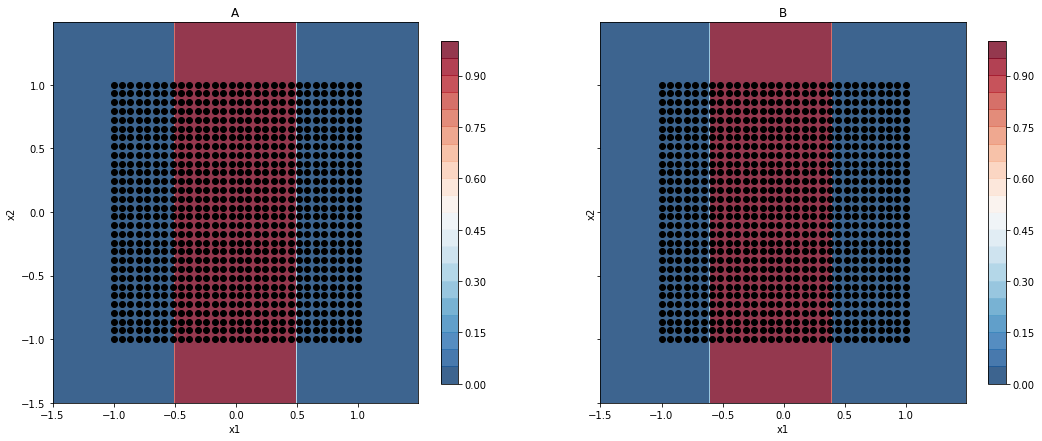

In [8]:
predict_proba_a = lambda X: clf_a.predict(X)
predict_proba_b = lambda X: clf_b.predict(X)

z_from, z_to = 0, 1
levels = np.linspace(z_from, z_to, 21)
mesh_step_size = .01

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size), np.arange(y_min, y_max, mesh_step_size))

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(2*9, 7))
for name, predict, ax in zip(('A', 'B'), (predict_proba_a, predict_proba_b), axs):
    Z = predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, levels, cmap=plt.cm.get_cmap('RdBu').reversed(), alpha=.8)
    fig.colorbar(cs, ax=ax, shrink=0.9)
    ax.scatter(X[:, 0], X[:, 1], c='k', edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_title(name)